In [1]:
%reset -fs
import pandas as pd
import  numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
from dask import dataframe as dd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.options.mode.use_inf_as_na = True

In [2]:
#Dask !!!
ddf = dd.read_csv(r"C:\Users\nated\Downloads\CSV-01-12\01-12\DrDoS_LDAP.csv", dtype={'SimillarHTTP': 'object'},blocksize='64MB')
df = ddf.compute()

In [3]:
df.columns = df.columns.str.replace(' ', '')

In [4]:
(df['Label'].value_counts()) / len(df) * 100

DrDoS_LDAP    99.926107
BENIGN         0.073893
Name: Label, dtype: float64

In [5]:
df.drop(columns=['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp', 'SimillarHTTP', 'SourcePort', 'DestinationPort'], inplace=True)

In [6]:
df.dropna(inplace=True)

In [7]:
cols = df.drop(columns=['Label']).columns.tolist()
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

In [8]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [9]:
X = df.drop(columns=["Label"], axis=1)
y = df['Label']


In [10]:
l_e = LabelEncoder()
y = l_e.fit_transform(y)

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000000, n_jobs=-1)

In [12]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=1)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, stratify=y_train_val, random_state=1)

In [14]:
X_train_scaled = pd.DataFrame(
    std.fit_transform(X_train),
    columns = X_train.columns)

In [15]:
import joblib
from dask.distributed import Client

client = Client(processes=False)

In [16]:
with joblib.parallel_backend("dask"):
    lr.fit(X_train_scaled, y_train)
    

In [17]:
from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix

In [18]:
X_val_scaled = pd.DataFrame(std.transform(X_val), columns = X_val.columns)

In [19]:
y_val_preds = lr.predict(X_val_scaled)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9999416242469528, Recall: 0.9999416242469528, F2 Score: 0.9999416242469529


In [20]:
lr_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [21]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in lr_confusion.flatten()/np.sum(lr_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

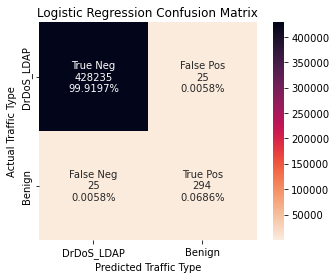

In [22]:
sns.heatmap(lr_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Logistic Regression Confusion Matrix');

Logistic Regression Model best F Beta2 score 1.000 at prob decision threshold >= 0.226
Logistic Regression Model best recall score 1.000 at prob decision threshold >= 0.010
Logistic Regression Model best precision score 1.000 at prob decision threshold >= 0.902


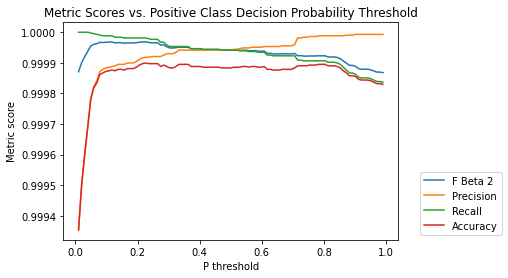

In [23]:
thresh_ps = np.linspace(0.01,0.99,101)
model_val_probs = lr.predict_proba(X_val_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

fbeta_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=2))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, fbeta_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F Beta 2','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_fbeta_score = np.max(fbeta_scores) 
best_thresh_p_fbeta = thresh_ps[np.argmax(fbeta_scores)]
best_recall_score = np.max(rec_scores)
best_thresh_p_rec = thresh_ps[np.argmax(rec_scores)]
best_prec_score = np.max(prec_scores)
best_thresh_p_prec = thresh_ps[np.argmax(prec_scores)]

print('Logistic Regression Model best F Beta2 score %.3f at prob decision threshold >= %.3f' 
      % (best_fbeta_score, best_thresh_p_fbeta))
print('Logistic Regression Model best recall score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_rec))
print('Logistic Regression Model best precision score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_prec))

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=2)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=2)

In [26]:
X_train_scaled = pd.DataFrame(
    std.fit_transform(X_train),
    columns = X_train.columns)

In [27]:
lr2 = LogisticRegression(solver='lbfgs', max_iter=1000000, n_jobs=-1, class_weight='balanced')

In [28]:
with joblib.parallel_backend("dask"):
    lr2.fit(X_train_scaled, y_train)

In [29]:
X_val_scaled = pd.DataFrame(std.transform(X_val), columns = X_val.columns)

In [30]:
y_val_preds = lr2.predict(X_val_scaled)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9999953291435751, Recall: 0.9998248727408584, F2 Score: 0.99985895937236


In [31]:
lr2_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [32]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in lr2_confusion.flatten()/np.sum(lr2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

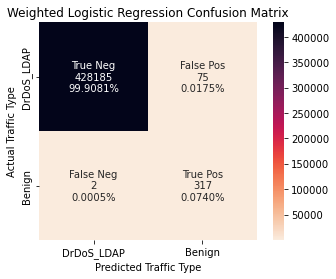

In [33]:
sns.heatmap(lr2_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Weighted Logistic Regression Confusion Matrix');

Balanced Logistic Regression Model best F Beta2 score 1.000 at prob decision threshold >= 0.010
Balanced Logistic Regression Model best recall score 1.000 at prob decision threshold >= 0.010
Balanced Logistic Regression Model best precision score 1.000 at prob decision threshold >= 0.461


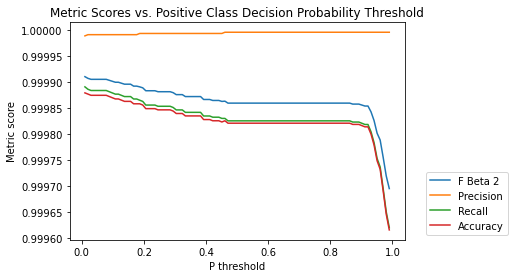

In [34]:
thresh_ps = np.linspace(0.01,0.99,101)
model_val_probs = lr2.predict_proba(X_val_scaled)[:,1] # positive class probs, same basic logistic model we fit in section 2 

fbeta_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    fbeta_scores.append(fbeta_score(y_val, model_val_labels, beta=2))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, fbeta_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F Beta 2','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_fbeta_score = np.max(fbeta_scores) 
best_thresh_p_fbeta = thresh_ps[np.argmax(fbeta_scores)]
best_recall_score = np.max(rec_scores)
best_thresh_p_rec = thresh_ps[np.argmax(rec_scores)]
best_prec_score = np.max(prec_scores)
best_thresh_p_prec = thresh_ps[np.argmax(prec_scores)]

print('Balanced Logistic Regression Model best F Beta2 score %.3f at prob decision threshold >= %.3f' 
      % (best_fbeta_score, best_thresh_p_fbeta))
print('Balanced Logistic Regression Model best recall score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_rec))
print('Balanced Logistic Regression Model best precision score %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p_prec))

In [35]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=3)

In [36]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=3)

In [37]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=3)

In [38]:
with joblib.parallel_backend("dask"):
    rf.fit(X_train, y_train)

In [39]:
y_val_preds = rf.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9999953299397563, Recall: 0.9999953299397563, F2 Score: 0.9999953299397562


In [40]:
rf_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [41]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf_confusion.flatten()/np.sum(rf_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

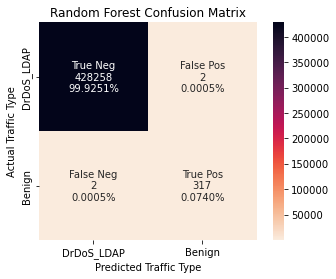

In [42]:
sns.heatmap(rf_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest Confusion Matrix');

In [43]:
rf2 = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=4, class_weight='balanced')

In [44]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=4)

In [45]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=4)

In [46]:
with joblib.parallel_backend("dask"):
    rf2.fit(X_train, y_train)

In [47]:
y_val_preds = rf2.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9999883249584368, Recall: 0.9999976649698781, F2 Score: 0.9999957969536318


In [48]:
rf2_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [49]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf2_confusion.flatten()/np.sum(rf2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

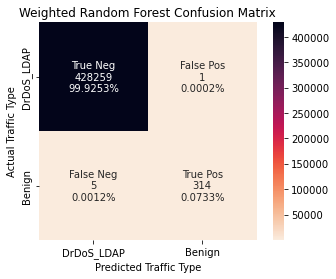

In [50]:
sns.heatmap(rf2_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Weighted Random Forest Confusion Matrix');

In [51]:
rf3 = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=5, class_weight='balanced_subsample')

In [52]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=5)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=5)

In [54]:
with joblib.parallel_backend("dask"):
    rf3.fit(X_train, y_train)

In [55]:
y_val_preds = rf3.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 0.9999929948932772, Recall: 0.9999906598795124, F2 Score: 0.999991126881393


In [56]:
rf3_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [57]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in rf3_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in rf3_confusion.flatten()/np.sum(rf3_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

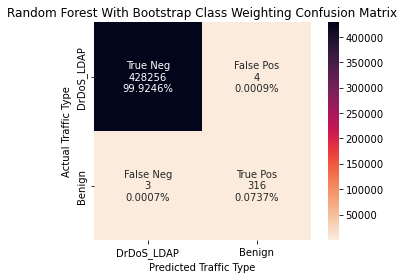

In [58]:
sns.heatmap(rf3_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest With Bootstrap Class Weighting Confusion Matrix');

In [62]:
imb_rf = BalancedRandomForestClassifier(n_estimators=1000, random_state=6, n_jobs=-1)

In [63]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=6)

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=6)

In [65]:
with joblib.parallel_backend("dask"):
    imb_rf.fit(X_train, y_train)

In [66]:
y_val_preds = imb_rf.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 1.0, Recall: 0.9993415215056274, F2 Score: 0.9994731478203359


In [67]:
imb_rf_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [68]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf_confusion.flatten()/np.sum(imb_rf_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

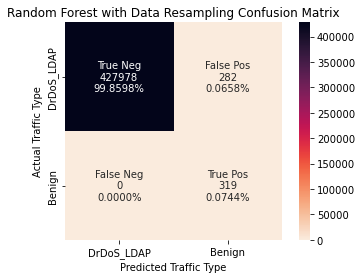

In [69]:
sns.heatmap(imb_rf_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling Confusion Matrix');

In [72]:
imb_rf2 = BalancedRandomForestClassifier(n_estimators=1000, random_state=7, class_weight='balanced', n_jobs=-1)

In [73]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=7)

In [74]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=7)

In [75]:
with joblib.parallel_backend("dask"):
    imb_rf2.fit(X_train, y_train)

In [76]:
y_val_preds = imb_rf2.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 1.0, Recall: 0.999329846355018, F2 Score: 0.9994638052174368


In [77]:
imb_rf2_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [78]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf2_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf2_confusion.flatten()/np.sum(imb_rf2_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

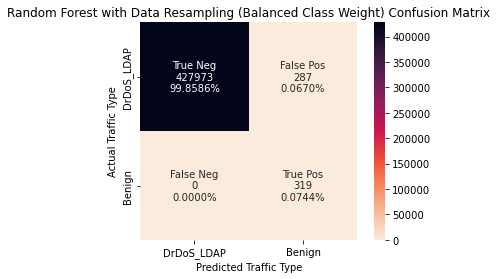

In [79]:
sns.heatmap(imb_rf2_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling (Balanced Class Weight) Confusion Matrix');

In [80]:
imb_rf3 = BalancedRandomForestClassifier(n_estimators=1000, random_state=8, class_weight='balanced_subsample', n_jobs=-1)

In [81]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y, random_state=8)

In [82]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = .25, stratify=y_train_val, random_state=8)

In [83]:
with joblib.parallel_backend("dask"):
    imb_rf3.fit(X_train, y_train)

In [90]:
y_val_preds = imb_rf3.predict(X_val)
print("Precision: {}, Recall: {}, F2 Score: {}".format(precision_score(y_val, y_val_preds), recall_score(y_val, y_val_preds), fbeta_score(y_val, y_val_preds, beta=2.0)))

Precision: 1.0, Recall: 0.9993998972586746, F2 Score: 0.9995198601802953


In [85]:
imb_rf3_confusion = confusion_matrix(y_val, y_val_preds, labels=[1, 0])

In [86]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in imb_rf3_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in imb_rf3_confusion.flatten()/np.sum(imb_rf3_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

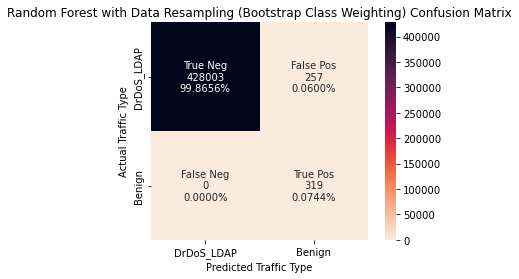

In [87]:
sns.heatmap(imb_rf3_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Random Forest with Data Resampling (Bootstrap Class Weighting) Confusion Matrix');